# MalURL Detector
---

## 1. Introduction
Here lies a classification model that aims to predict the maliciousnes of any given URL. The notebook is a collection of data cleaning, feature engineering and modelling steps, that combine to deliver the MalURL Detector. The model is based on a set of reputational and lexical features. 

| Sections              | Description   |
| :---------------------|:---------------|
| Introduction         | Introduction to the MalURL Detector |
| Setup                | Import foundational and machine learning libraries |
| Data Ingestion       | Ingest and clean the URL and IANA data sets    |
| Feature Engineering  | Extract and engineer the set of reputational and lexical features|
| Modeling             | Train and tune the Random Forest classifier, then make some predictions |


Next steps:
* Consider new reputational features i.e. last updated
* Use binary encoding for categorical features rather than Label Encoder
* Conduct further model tuning and deepen understanding of Random Forest and other candidate classifiers
* Handling of unseen values in test phase i.e. categorical features and encodings
* More to come...

## 2. Setup

First we setup the generic notebook requirements.

In [ ]:
!pip install python-whois
!pip install datetime
!pip install tldextract

In [64]:
# iPython and Notebook config
import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt

import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score ,recall_score, precision_score, confusion_matrix

import utils

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results
%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%matplotlib inline

We also need the various SageMaker bits and pieces.

In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

### Setup utilities for feature extraction

In [12]:
import whois
from datetime import datetime

def creation_date(domain_name):
    """
    Gets creation date of domain
    """
    
    # Get creation date of Domain 
    domain_name = whois.whois(domain_name).creation_date
    
    # Handling exceptions
    if type(domain_name) is list:
        return domain_name[0]
    elif str(domain_name).find('Aug'):
        domain_name = "1996-07-01 00:00:01"
        return domain_name
    elif domain_name == np.nan:
        currentDT = datetime.now()
        domain_name = currentDT.strftime("%Y-%m-%d %H:%M:%S")
        return domain_name
    else:
        return domain_name

In [13]:
def countSpecial(x):
    """
    Counts number of special characters in a string
    """
    new = re.sub('[\w]+' ,'', x)
    return len(new)

In [14]:
def entropy(string):
    """
    Calculates the Shannon entropy of a string
    """

    # Get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # Calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy

In [15]:
from socket import gethostbyname, gaierror

def host_ip(domain):
    """
    Gets Host IP of Domain
    """

    # Get HOST IP     
    try:
        host = gethostbyname(domain)
        return host
    except gaierror:
        return 'missing'

In [16]:
import tldextract

def get_domain_parts(df, feature_col):
    """
    Extract domain components
    """
    
    # Extract domain
    df['domain'] = df[feature_col].apply(lambda x: tldextract.extract(x).domain)
    
    # Extract suffix
    df['suffix'] = df[feature_col].apply(lambda x: tldextract.extract(x).suffix)
    
    # Extract suffix
    df['domain_name'] = df[feature_col].apply(lambda x: tldextract.extract(x).registered_domain)
    
    # TODO - Handle null domain and suffix
    
    return df

In [17]:
def get_host_ip(df, domain_col):
    """
    Gets host IP address associated with domain
    """
    
    # Extract Host IP 
    df['host_ip'] = df[domain_col].apply(lambda x: host_ip(x))
    
    # TODO - Handle null hosts
    
    return df

In [18]:
def get_prefix(df, host_col):
    """
    Gets first octet of IP
    """
    
    # Extract prefix, first octet
    df['prefix'] = df[host_col].str.extract('(\d+)\.').astype(float, errors='ignore').astype(str)
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].replace('nan', 'missing')
    
    return df   

In [19]:
def get_creation_date(df, feature_col):
    """
    Gets creation date of domain
    """
    
    df['domain_creation'] = df[feature_col].apply(lambda x: creation_date(x))

    return df

In [20]:
def get_time_features(df, date_col):
    """
    Calculates days since date.
    """
      
    # Cast date_col to datetime
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    
    # Calculate days since date
    df['days_since_' + date_col] = pd.datetime.today().date() - df[date_col].dt.date
    df['days_since_' + date_col] = df['days_since_' + date_col].astype(str).str.extract("(\d+)").astype(float)

    df[date_col + "_day"] = df[date_col].dt.day
    df[date_col + "_month"] = df[date_col].dt.month
    df[date_col + "_year"] = df[date_col].dt.year
    
    return df

In [21]:
def get_domain_entropy(df, feature_col):
    """
    Calculates entropy of a feature for a given data set
    """
    
    # Calculate entropy 
    df['entropy'] = df[feature_col].apply(lambda x: entropy(str(x)))

    return df

In [22]:
def get_number_suffix(df, feature_col):
    """
    Calculates number of suffix in the URL
    """
    
    # Calculates number of suffix in the URL
    df['number_suffix'] = df[feature_col].str.count('\.')
    
    return df

In [23]:
def get_number_digits(df, feature_col):
    """
    Calculates number of numerical characters in a string
    """
    
    # Calculates number of digits
    df['number_digits'] = df[feature_col].str.count('[0-9]')
    
    return df

In [24]:
def get_percent_digits(df):
    """
    Calculates percentage of string is a digit
    """
    
    # Calculate percentage
    df['digits_percentage'] = (df['number_digits']/df['string_length'])*100
    
    return df

In [25]:
def get_string_length(df, feature_col):
    """
    Calculates length of string
    """

    # Calculates length of string
    df['string_length'] = df[feature_col].str.len()
    
    return df

In [26]:
def get_specials(df, feature_col):
    """
    Calculates number of special characters in string
    """
    
    # Count of special characters
    df['specials'] = df[feature_col].apply(lambda x: countSpecial(str(x)))
   
    return df

In [27]:
def get_iana_designations(df, iana, prefix_col):
    """
    Merges data sets on the prefix i.e. first octect of the IPv4 address
    """

    # Enrich sample with IPv4 Registry data
    df = df.merge(iana, on=prefix_col, how='left')

    # Clean prefix and drop unneeded columns
    df['prefix'] = df['prefix'].astype(str)
    df['designation'] = df['designation'].fillna('missing')
    df.rename(columns={ 'status [1]': 'status'}, inplace=True)
    df.drop(['note'], axis=1, inplace=True)

    return df

## 3. Load and prepare data

#### Option 1 - BYOD
Schema {url, malicious/benign}

In [30]:
# !wget -O ../data/<filename> <url/filename>

#### Option 2 - Use malicious URL dataset

In [31]:
import pandas as pd

# Ingest sample dataset
data = pd.read_csv("data/mal_url_dataset.csv", index_col=0)

In [32]:
import re

# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float',errors='ignore').astype(str)

print(str(iana.shape[0]) + " samples")

iana.head()

256 samples


,prefix,designation,date,whois,rdap,status [1],note
0,0.0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1.0,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2.0,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3.0,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4.0,Administered by ARIN,1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


In [36]:
def feature_extraction(data, iana_data):
    """
    Extracts reputational, lexical and host features.
    """
    
    # Assumes string or dataframe input
    
    # Handle string or dataframe input
    if not isinstance(data, pd.DataFrame):
        df = pd.DataFrame(data=[data], columns=['url']) # Create dataframe from string  
    else:
        df = data
    
    # Conduct extraction
    print('  * Loading features')
    df = get_domain_entropy(df, 'domain_name') # Extract domain entropy
    df = get_time_features(df, 'create_date') 
    df = get_time_features(df, 'updated_date') 
    df = get_time_features(df, 'expiration_date') 
    df = get_number_suffix(df, 'domain_name') # Extract number of suffix
    df = get_number_digits(df, 'domain_name') # Extract number of digits
    df = get_string_length(df, 'domain_name') # Extract string length
    df = get_percent_digits(df) # Extract percentage digits
    df = get_specials(df, 'domain_name') # Extract number of specials
    df = get_prefix(df, 'host_ip')
    df = get_iana_designations(df, iana_data, 'prefix') # Extract designation
    
    print('  * Number of features extracted: ' + str(len(df.columns.tolist())))
    
    return df

In [37]:
data = feature_extraction(data, iana)

  * Loading features
  * Number of features extracted: 39


In [38]:
data

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,number_digits,string_length,digits_percentage,specials,prefix,designation,date,whois,rdap,status
0,kancloud.cn,benign,kancloud.cn,kancloud,cn,2015-02-15 11:45:13,NaT,2020-02-15 11:45:13,NaN,NaN,...,0.0,11.0,0.000000,1,123.0,APNIC,2006-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED
1,answers.com,benign,answers.com,answers,com,1996-05-20 04:00:00,2018-11-05 20:13:51,2021-12-11 17:46:50,NaN,NaN,...,0.0,11.0,0.000000,1,151.0,Administered by RIPE NCC,1993-05,whois.ripe.net,https://rdap.db.ripe.net/,LEGACY
2,edf.fr,benign,edf.fr,edf,fr,1994-12-31 23:00:00,2019-02-03 06:44:06,2020-02-07 23:00:00,NaN,NaN,...,0.0,6.0,0.000000,1,163.0,Administered by APNIC,1993-05,whois.apnic.net,https://rdap.apnic.net/,LEGACY
3,fushaar.com,benign,fushaar.com,fushaar,com,2014-05-09 14:39:34,NaT,2021-05-09 14:39:34,Arizona,US,...,0.0,11.0,0.000000,1,missing,missing,NaN,NaN,NaN,NaN
4,vc.ru,benign,vc.ru,vc,ru,2004-08-02 20:00:00,NaT,2019-08-02 21:00:00,NaN,NaN,...,0.0,5.0,0.000000,1,85.0,RIPE NCC,2004-04,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED
5,foursquare.com,benign,foursquare.com,foursquare,com,2002-03-26 01:18:55,NaT,2021-03-26 00:18:55,New York,US,...,0.0,14.0,0.000000,1,151.0,Administered by RIPE NCC,1993-05,whois.ripe.net,https://rdap.db.ripe.net/,LEGACY
6,myqcloud.com,benign,myqcloud.com,myqcloud,com,NaT,NaT,NaT,Guang Dong,CN,...,0.0,12.0,0.000000,1,missing,missing,NaN,NaN,NaN,NaN
7,ctfile.com,benign,ctfile.com,ctfile,com,2014-12-12 07:13:59,2018-12-12 09:05:46,2019-12-12 07:13:59,ON,CA,...,0.0,10.0,0.000000,1,183.0,APNIC,2009-04,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED
8,https://vakantieverhuur.be/captcha/recaptcha/c...,malicious,vakantieverhuur.be,vakantieverhuur,be,NaT,NaT,NaT,NaN,NaN,...,0.0,18.0,0.000000,1,185.0,RIPE NCC,2011-02,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED
9,ning.com,benign,ning.com,ning,com,2003-12-16 19:21:12,2018-10-29 09:48:02,2023-12-16 19:21:12,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,...,0.0,8.0,0.000000,1,208.0,ARIN,1996-04,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,ALLOCATED


In [39]:
def record_cleaner(df):
    """Cleans and imputes missing and old values."""
    
    # Cleaning prefix
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].replace('nan', 'missing')
    
    # Clean missing dates
    currentDT = datetime.now()
    dt_now = currentDT.strftime("%Y-%m-%d %H:%M:%S")
    df['create_date'] = df['create_date'].fillna(dt_now)
    df['updated_date'] = df['updated_date'].fillna(dt_now)
    df['expiration_date'] = df['expiration_date'].fillna(dt_now)


#     # Clean old dates
#     older_dt = "1996-07-01 00:00:01"
#     df.loc[df['create_date'].str.contains('Aug'), 'create_date'] = older_dt
#     df.loc[df['updated_date'].str.contains('Aug'), 'updated_date'] = older_dt
#     df.loc[df['expiration_date'].str.contains('Aug'), 'expiration_date'] = older_dt
    
    # Clean missing hosts
#     df = df.fillna('missing')

    # Get rid of numbered suffix entries
#     df = df[~df['suffix'].str.contains('\d')]
    
    return df

In [40]:
data = record_cleaner(data)

In [41]:
drop_cols = ['status', 'emails', 'registrar', 
            'date', 'domain', 'domain_name',
            'url', 'create_date', 'updated_date',
            'expiration_date', 'host_ip']

In [42]:
data = data.drop(columns=drop_cols)

In [44]:
cat_cols = ['prefix', 'whois_server', 'whois', 
            'suffix', 'designation', 'rdap', 'state', 'country']

In [53]:
def feature_engineering(df, cat_cols): 
    """
    Conduct encoding, normalisation and standardisation of features
    """
    
    df[cat_cols] = df[cat_cols].fillna('missing')
    
    # Setup Label Encoders
    prefix = LabelEncoder()
    whois_s = LabelEncoder()
    whois = LabelEncoder()
    suffix = LabelEncoder()
    designation = LabelEncoder()
    rdap = LabelEncoder()
    state = LabelEncoder()
    country = LabelEncoder()
    class_l = LabelEncoder()

    # Fit labels and transform data
    df['prefix'] = prefix.fit_transform(df['prefix'])
    df['whois_server'] = whois_s.fit_transform(df['whois_server'])
    df['whois'] = whois.fit_transform(df['whois'])
    df['suffix'] = suffix.fit_transform(df['suffix'])
    df['designation'] = designation.fit_transform(df['designation'])
    df['rdap'] = rdap.fit_transform(df['rdap'])
    df['state'] = state.fit_transform(df['state'])
    df['country'] = country.fit_transform(df['country'])
    df['class'] = class_l.fit_transform(df['class'])


    
    # Save encodings
    np.save('prefix.npy', prefix.classes_)
    np.save('whois_s.npy', whois_s.classes_)
    np.save('whois.npy', whois.classes_)
    np.save('suffix.npy', suffix.classes_)
    np.save('designation.npy', designation.classes_)
    np.save('rdap.npy', rdap.classes_)
    np.save('state.npy', rdap.classes_)
    np.save('country.npy', rdap.classes_)    
    np.save('class.npy', class_l.classes_)
    
    return df

In [54]:
data = feature_engineering(data, cat_cols)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [322]:
data

,class,suffix,state,country,whois_server,entropy,days_since_create_date,create_date_day,create_date_month,create_date_year,days_since_updated_date,updated_date_day,updated_date_month,updated_date_year,days_since_expiration_date,expiration_date_day,expiration_date_month,expiration_date_year,number_suffix,number_digits,string_length,digits_percentage,specials,prefix,designation,whois,rdap
0,0,46,659,157,17,3.095795,1788.0,15.0,2.0,2015.0,NaN,NaN,NaN,NaN,38.0,15.0,2.0,2020.0,1.0,0.0,11.0,0.000000,1,26,1,2,1
1,0,63,659,157,144,3.277613,8633.0,20.0,5.0,1996.0,429.0,5.0,11.0,2018.0,703.0,11.0,12.0,2021.0,1.0,0.0,11.0,0.000000,1,56,8,5,3
2,0,136,659,157,17,2.251629,9139.0,31.0,12.0,1994.0,339.0,3.0,2.0,2019.0,30.0,7.0,2.0,2020.0,1.0,0.0,6.0,0.000000,1,68,5,2,1
3,0,63,51,126,94,3.277613,2070.0,9.0,5.0,2014.0,NaN,NaN,NaN,NaN,487.0,9.0,5.0,2021.0,1.0,0.0,11.0,0.000000,1,198,16,0,5
4,0,296,659,157,17,2.321928,5637.0,2.0,8.0,2004.0,NaN,NaN,NaN,NaN,159.0,2.0,8.0,2019.0,1.0,0.0,5.0,0.000000,1,183,14,5,3
5,0,63,384,126,91,3.378783,6497.0,26.0,3.0,2002.0,NaN,NaN,NaN,NaN,443.0,26.0,3.0,2021.0,1.0,0.0,14.0,0.000000,1,56,8,5,3
6,0,63,202,27,124,3.084963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,12.0,0.000000,1,198,16,0,5
7,0,63,403,23,96,3.121928,1853.0,12.0,12.0,2014.0,392.0,12.0,12.0,2018.0,27.0,12.0,12.0,2019.0,1.0,0.0,10.0,0.000000,1,90,1,2,1
8,1,23,659,157,17,3.461320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,18.0,0.000000,1,92,14,5,3
9,0,63,444,104,194,2.750000,5867.0,16.0,12.0,2003.0,436.0,29.0,10.0,2018.0,1438.0,16.0,12.0,2023.0,1.0,0.0,8.0,0.000000,1,117,2,3,2


In [55]:
# Let's grab the input data and target variables
mal_X_df = data.loc[:, data.columns != 'class']
mal_Y_df = data.loc[:, data.columns == 'class']

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(mal_X_df, mal_Y_df, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## 4. Uploading the training and validation files to S3

### Save the data locally

In [56]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [57]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

In [59]:
prefix = 'mal-url-xgboost-deploy-ll'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## 5. Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [60]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. You may wish to change these to see what effect
# there is on the resulting model.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "binary:logistic",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

### Execute the training job

In [61]:
# First we need to choose a training job name. This is useful for if we want to recall information about our
# training job at a later date. Note that SageMaker requires a training job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [62]:
session.logs_for_job(training_job_name, wait=True)

2020-01-08 08:31:33 Starting - Launching requested ML instances......
2020-01-08 08:32:35 Starting - Preparing the instances for training...
2020-01-08 08:33:19 Downloading - Downloading input data...
2020-01-08 08:33:41 Training - Downloading the training image...
2020-01-08 08:34:09 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[08:34:11] 4489x26 matrix with 116714 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:ro

### Build the model

Now that the training job has completed, we have some model artifacts which we can use to build a model. Note that here we mean SageMaker's definition of a model, which is a collection of information about a specific algorithm along with the artifacts which result from a training job.

In [66]:
# We begin by asking SageMaker to describe for us the results of the training job. The data structure
# returned contains a lot more information than we currently need, try checking it out yourself in
# more detail.
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [67]:
# Just like when we created a training job, the model name must be unique
model_name = training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## 6. Testing the model

### Set up the batch transform job

In [68]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Execute the batch transform job

Now that we have created the request data structure, it is time to ask SageMaker to set up and run our batch transform job. Just like in the previous steps, SageMaker performs these tasks in the background so that if we want to wait for the transform job to terminate (and ensure the job is progressing) we can ask SageMaker to wait of the transform job to complete.

In [69]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [70]:
transform_desc = session.wait_for_transform_job(transform_job_name)

..............................................!


### Analyze the results

Now that the transform job has completed, the results are stored on S3 as we requested. Since we'd like to do a bit of analysis in the notebook we can use some notebook magic to copy the resulting output from S3 and save it locally.

In [71]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [72]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-ap-southeast-2-999752527953/mal-url-xgboost-deploy-ll/batch-bransform/test.csv.out to data/test.csv.out


In [73]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
Y_pred = [round(num) for num in Y_pred.squeeze().values]

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.7803030303030303

Confusion matrix:
 [[1320  319]
 [ 406 1255]]


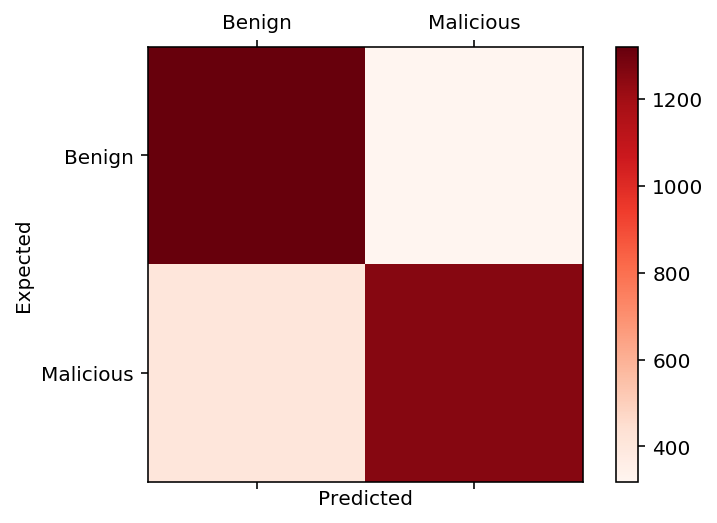

In [75]:
# Confusion matrix
conf_mat = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');